# Import packages

### Import python packages

In [1]:
import re,os
os.environ["CUDA_VISIBLE_DEVICES"]="7"
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from IPython.display import clear_output
import pandas as pd
import math
import random
from datetime import datetime
from scipy.stats import linregress
from sklearn.decomposition import PCA
from tqdm import trange, tqdm
from mpl_toolkits.mplot3d import Axes3D
import plotly.express as px
import plotly.graph_objects as go
from sklearn.manifold import TSNE
tfk = tf.keras
tfkl = tf.keras.layers
clear_output()

### Import custom packages

In [2]:
from MRA_generate import MRA_generate
from symae_model import SymAE, SymAE_Dense
from parameters import *
from redatuming import redatuming
from latent import latent
from plot_training import plot_training
from plot_redatuming import plot_redatuming
from plot_save import plot_save

Num GPUs Available:  1
TensorFlow Version:  2.9.1


# Generate dataset X

### Define $n_\varepsilon$ states

g(n,x) satisfies $n=0,1...,n_\varepsilon$, $x \in [0,1)$  
g(n,$\cdot$) is the n-th state.
state = real object without 

Text(0.5, 0.98, 'Show the shape of all $n_\\epsilon$ = 2 states')

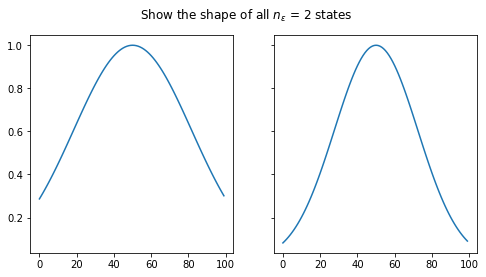

In [3]:
def g(n,x):
    if n==0:
        return math.e**(-5*(x-0.5)**2)
    elif n==1:
        return math.e**(-10*(x-0.5)**2)
fig, axs = plt.subplots(1, ne, sharex=True, sharey=True, figsize=(ne*4, 4))
for i in range(ne):
    axs[i].plot(range(d), [g(i,x/d) for x in range(d)])
plt.suptitle('Show the shape of all $n_\epsilon$ = %d states'%ne)

### Generate the dataset

If replace==0, without replacement everywhere. Must $n_x*n_t <= n_\varepsilon*d$ and $n_t <= d$.  
If replace==1, X[i,:] have different nuisances, but each block in D can appear multiple times in X.  
If replace==2, with replacement everywhere.  
The default is replace=1.

In [4]:
MRA_training = MRA_generate(d,nt,N,sigma,ne,g,replace=0)
MRA_training.generate_default()
X = MRA_training.X

### Print the structure of dataset X

Plot how many times each block in D appears in X

Numbers of each state in X:
0    50
1    50
dtype: int64


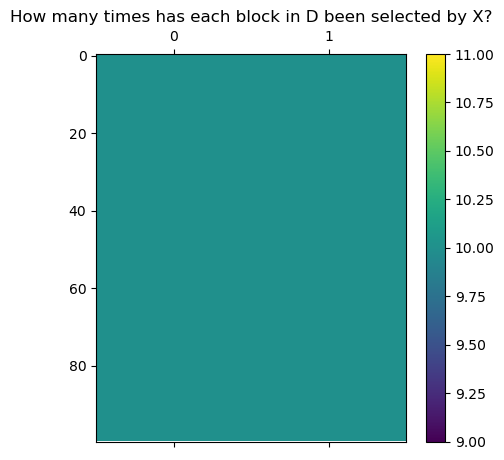

In [5]:
print("Numbers of each state in X:")
print(pd.DataFrame(MRA_training.states).value_counts())
select_times = MRA_training.select_times
plt.figure(figsize=(5,5),dpi=100)
plt.matshow(select_times.T, aspect='auto', fignum=1)
plt.colorbar()
plt.title('How many times has each block in D been selected by X?')
plt.show()

# Train SymAE

### Initialize SymAE and load weights

In [6]:
model = SymAE(N,nt,d,p,q,kernel_size,filters,dropout_rate)
model.load_weights('./checkpoint/p=3,q=3,ne=2')
clear_output()

In [7]:
dropout_rate, q

(0.5, 3)

In [8]:
model.latentcat.drop.rate = 0.
model.latentcat.drop.stddev = 0.05

### Select the optimizer

In [9]:
Adam = tf.keras.optimizers.Adam(learning_rate=0.001,beta_1=0.9,beta_2=0.999,epsilon=1e-08)
SGD = tf.keras.optimizers.SGD(learning_rate=0.001,momentum=0.0,nesterov=False)
model.compile(loss='mse',optimizer=Adam)

### Train the NeuralNet

M: how many epochs you use

In [11]:
M = 1000 # How many epochs
epochs = range(M)
losses = [np.nan]*M
MRA_pca = MRA_generate(d,nt,1000,sigma,ne,g,replace=0)
pca_cb = PCA(n_components=3)
MRA_pca.generate_default()
X = MRA_training.X
clear_output()
N_shifts = MRA_pca.shifts.reshape(-1,1)
N_states = np.repeat(MRA_pca.states,nt)
df_states = pd.DataFrame(N_states,columns=['state']).astype('object') 
df_shifts = pd.DataFrame(N_shifts,columns=['shift'])
class CustomCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        losses[epoch] = logs["loss"]
        print("For epoch {:d}, loss is {:f}.".format(epoch, logs["loss"]))
        if epoch % 200 == 0:
            clear_output(wait = True)
            _, Ns = latent(model,MRA_pca)
            N_reshaped = Ns.reshape(-1,q)
            pca_N = pca_cb.fit_transform(N_reshaped)
            df = pd.DataFrame(pca_N, columns = ['1st','2nd','3rd'][0:3])
            df = pd.concat([df,df_states,df_shifts],axis=1)
            #fig = px.scatter(df, x='1st', y='2nd', color='state', text='shift', title='q=%d,loss=%f'%(q,logs["loss"]))
            fig = px.scatter_3d(df, x='1st', y='2nd', z='3rd', color='state', text='shift', title='q=%d,loss=%f'%(q,logs["loss"]))
            fig.update_layout(height=500)
            fig.show()
history = model.fit(X,X,epochs=M,verbose=0,callbacks=[CustomCallback()])

For epoch 801, loss is 0.000235.
For epoch 802, loss is 0.000206.
For epoch 803, loss is 0.000203.
For epoch 804, loss is 0.000213.
For epoch 805, loss is 0.000208.
For epoch 806, loss is 0.000233.
For epoch 807, loss is 0.000236.
For epoch 808, loss is 0.000281.
For epoch 809, loss is 0.000252.
For epoch 810, loss is 0.000236.
For epoch 811, loss is 0.000239.
For epoch 812, loss is 0.000318.
For epoch 813, loss is 0.000322.
For epoch 814, loss is 0.000542.
For epoch 815, loss is 0.000438.
For epoch 816, loss is 0.000506.
For epoch 817, loss is 0.000373.
For epoch 818, loss is 0.000334.
For epoch 819, loss is 0.000238.
For epoch 820, loss is 0.000295.
For epoch 821, loss is 0.000276.
For epoch 822, loss is 0.000313.
For epoch 823, loss is 0.000277.
For epoch 824, loss is 0.000238.
For epoch 825, loss is 0.000241.
For epoch 826, loss is 0.000212.
For epoch 827, loss is 0.000192.
For epoch 828, loss is 0.000207.
For epoch 829, loss is 0.000203.
For epoch 830, loss is 0.000188.
For epoch 

### Plot loss-epoch graph

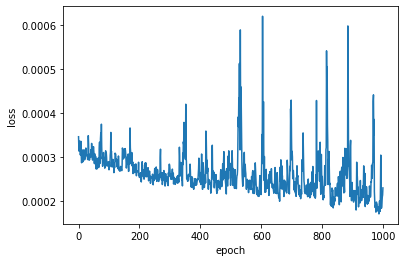

In [12]:
plt.plot(epochs,losses)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

### Save weights

In [13]:
model.save_weights('./checkpoint/'+'p=%d,q=%d,ne=2'%(p,q))
print("weights saved")

weights saved


### Visualize the training result

find_state(state): Generate a data set, whose shape is $(1,n_\tau,d)$, and its state equal to the input of this function

1/1 [==============================] - 1s 654ms/step


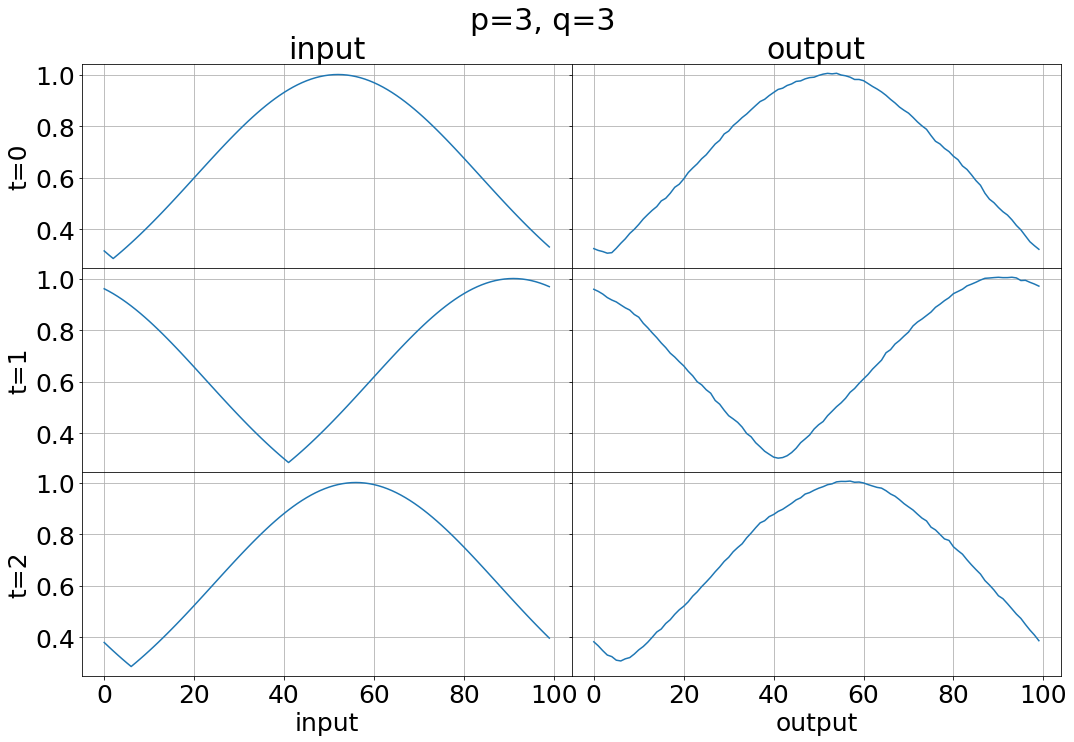

In [14]:
def find(state,nuisance):
    '''
    Generate a dataset with N=1 and this specific state

    Parameters
    ----------
    state : int
        The state you want
        
    Returns
    ----------
    MRA_data : class MRA_generate
    '''
    MRA_data = MRA_generate(d,nt,1,sigma,ne,g,replace=1)
    for i in range(1000):
        MRA_data.generate_default()
        if MRA_data.states[0] != state:
            continue
        for j in range(nt):
            if MRA_data.shifts[0][j] == nuisance:
                return MRA_data, j
test_X = find(0,0)[0].X
fig = plot_training(model,test_X)

### Save plot

In [ ]:
plot_save(fig,ID=-1)

# Redatuming

### Choose which 2 states and shifts you want to redatum 

In [15]:
MRA1, t1 = find(0,0)
MRA2, t2 = find(1,36)

### Redatuming and the visualize it

The MSE of C1N2 is: 0.103901
The MSE of C2N1 is:0.171304


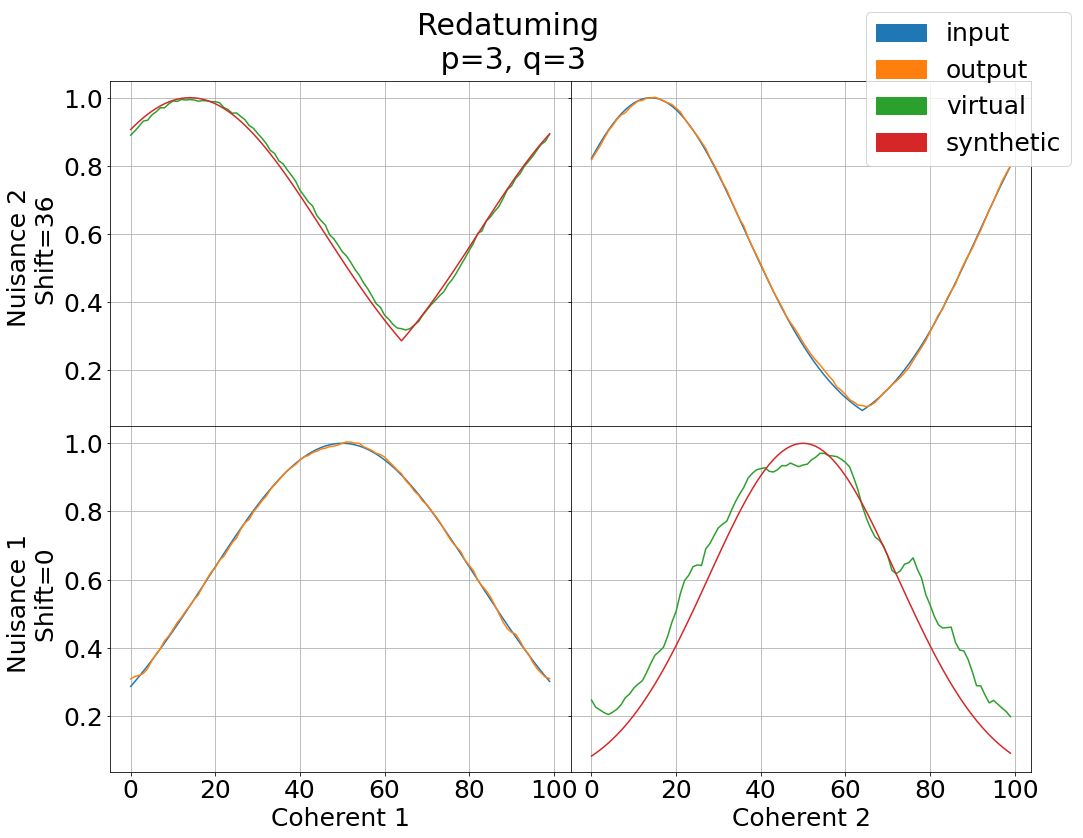

In [16]:
redatum = redatuming(model,MRA1,MRA2,t1,t2)
MSE_C1_N2, MSE_C2_N1 = redatum.MSE()
fig = plot_redatuming(redatum)
clear_output()
print('The MSE of C1N2 is: %f'%MSE_C1_N2)
print('The MSE of C2N1 is:%f'%MSE_C2_N1)

### Save redatuming plot

In [ ]:
plot_save(fig,ID=-1)

### List many redatuming

In [17]:
def dec(latent_code):
    tem = latent_code[np.newaxis, np.newaxis, :]
    tem = np.repeat(tem, nt, axis=1)
    tem = model.mixer.predict(tem, verbose=0)
    return tem[0,0,:]
def enc(state, shift):
    tem = np.array( [g(state, ((k+shift)%d)/d) for k in range(d)] )
    tem = tem[np.newaxis, np.newaxis, :, np.newaxis]
    tem = np.repeat(tem, nt, axis=1)
    tem = model.encoder.predict(tem, verbose=0)
    return tem[0][0:p+q]

100%|█████████████████████████████████████████| 100/100 [00:19<00:00,  5.03it/s]


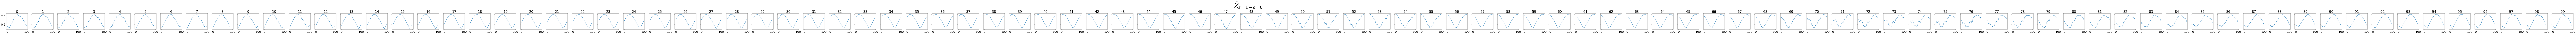

FileNotFoundError: [Errno 2] No such file or directory: './plots/1to0.png'

In [18]:
state_source = 0
nuisance_source = 1
fig, axs = plt.subplots(1, d, sharex=True, sharey=True, figsize=(4*d,4), dpi=40)
for i in trange(d):
    coherent_code = enc(state_source, 0)[0: p]
    nuisance_code = enc(nuisance_source, i)[p: p+q]
    latent_code = np.concatenate([coherent_code, nuisance_code], axis=0)
    axs[i].plot(range(d), dec(latent_code))
    axs[i].set_title('%d'%i)
plt.suptitle('$\hat{X}_{s=%d \mapsto s=%d}$'%(nuisance_source, state_source), fontsize=50)
plt.subplots_adjust(top=0.6)
plt.show()
#fig.savefig('./plots/%dto%d'%(nuisance_source, state_source))

# 3d-PCA of latent space

Repeat the same thing as 2d-PCA did, but the target dimension of PCA is switched to 3.

### Initialize MRA and PCA

In [ ]:
pca = PCA(n_components=3)
MRA_pca = MRA_generate(d,nt,1000,sigma,ne,g,replace=1)
MRA_pca.generate_default()
Cs,Ns = latent(model,MRA_pca)

### PCA of p-space

In [ ]:
pca.fit(Cs)
pca_C = pca.fit_transform(Cs)
df = pd.DataFrame(pca_C, columns = ['1st','2nd','3rd'])
tem = pd.DataFrame(MRA_pca.states,columns=['state']).astype('object')
df = pd.concat([df,tem],axis=1)
fig = px.scatter_3d(df, x='1st', y='2nd', z='3rd', color='state')
fig.show()

### PCA of q-space of one specific state

In [ ]:
state = 0
N_reshaped = Ns[MRA_pca.states==state,:].reshape(-1,q) 
N_shifts = MRA_pca.shifts[MRA_pca.states==state,:].reshape(-1,1)
pca = PCA(n_components=3)
pca.fit(N_reshaped)
pca_N = pca.fit_transform(N_reshaped)
df = pd.DataFrame(pca_N, columns = ['1st','2nd','3rd'])
tem = pd.DataFrame(N_shifts,columns=['shift'])
df = pd.concat([df,tem],axis=1)
fig = px.scatter_3d(df, x='1st', y='2nd', z='3rd', color='shift')
fig.show()

### PCA in q-space of all states

In [ ]:
N_reshaped = Ns.reshape(-1,q)
N_shifts = MRA_pca.shifts.reshape(-1,1)
pca.fit(N_reshaped)
pca_N = pca.fit_transform(N_reshaped)
df = pd.DataFrame(pca_N, columns = ['1st','2nd','3rd'])
df_states = pd.DataFrame(np.repeat(MRA_pca.states,nt),columns=['state']).astype('object')
df_shifts = pd.DataFrame(N_shifts,columns=['shift'])
df = pd.concat([df,df_states,df_shifts],axis=1)
fig = px.scatter_3d(df, x='1st', y='2nd', z='3rd', color='state')
fig.show()

# 2d-PCA of latent space

### Initialize PCA data

In [ ]:
MRA_pca = MRA_generate(d,nt,1000,sigma,ne,g,replace=1)
MRA_pca.generate_default()
Cs, Ns = latent(model,MRA_pca)
pca = PCA(n_components=2)

### Plot PCA of p-space

p-space is another name of the latent coherent space

In [ ]:
pca_C = pca.fit_transform(Cs)
center = np.empty((ne,2))
fig = plt.figure(figsize=(5,4),dpi=100)
for i in range(ne):
    center[i,:] = sum(pca_C[MRA_pca.states==i,:])/sum(MRA_pca.states==i)
    plt.text(center[i,0],center[i,1],"state=%d"%i,fontsize=15)
for i in trange(1000):
    plt.scatter(pca_C[i,0],pca_C[i,1],color='C%d'%(MRA_pca.states[i]))
plt.title('PCA of p-space',fontsize=15)
plt.tick_params(labelsize=15)
plt.tight_layout()

### Plot PCA of q-space, only use one state

q-space is another name of latent nuisance space

In the plot below we see a "torus" or a "ring", which makes a lot of sense, because the nuisance code $\mathbb{Z}_d$ behaves like a "loop".

In [ ]:
state = 2
N_reshaped = Ns[MRA_pca.states==state,:].reshape(-1,q)
N_shifts = MRA_pca.shifts[MRA_pca.states==state,:]
pca.fit(N_reshaped)
pca_N = pca.fit_transform(N_reshaped)
fig = plt.figure(figsize=(16,12),dpi=100)
for i in trange(1000):
    plt.scatter(pca_N[i,0],pca_N[i,1],color='C0')
    plt.text(pca_N[i,0],pca_N[i,1],"shift=%d"%N_shifts[i//nt,i%nt],fontsize=15)
plt.title('PCA of q-space of state %d'%state,fontsize=25)
plt.tick_params(labelsize=25)

### PCA of q-space uisng all states

In SymAE, we hope the latent nuisance code only depends on the nuisance part of the data, but has no relationship with which state it is.  
In the plot, different colors denote latent nuisance code from different states.  
So ideally, we hope all the 4 "ring" (of 4 different colors) shown in the plot are perfectly overlapped with each other.     
But that's not what is shown in the plot below. This indicates that redauming won't be successful.

In [ ]:
N_reshaped = Ns.reshape(-1,q)
pca = PCA(n_components=2)
pca.fit(N_reshaped)
pca_N = pca.transform(N_reshaped)
fig = plt.figure(figsize=(16,12),dpi=100)
for i in trange(2000):
    plt.scatter(pca_N[i,0],pca_N[i,1],color='C%d'%(MRA_pca.states[i//nt]))
    plt.text(pca_N[i,0],pca_N[i,1],"%d"%MRA_pca.shifts[i//nt,i%nt],fontsize=15,fontweight='ultralight')
plt.title('PCA of q-space of all states',fontsize=25)
plt.tick_params(labelsize=25)
blue_patch = mpatches.Patch(color='C0', label='state=0')
orange_patch = mpatches.Patch(color='C1', label='state=1')
green_patch = mpatches.Patch(color='C2', label='state=2')
red_patch = mpatches.Patch(color='C3', label='state=3')
plt.legend(handles=[blue_patch,orange_patch,green_patch,red_patch])
#plt.tight_layout()
#plt.xlim(-5,5)
#plt.ylim(-5,5)
plt.show()